https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Он содержит только числовые входные переменные, которые являются результатом преобразования методом главных компонент (PCA). К сожалению, из-за вопросов конфиденциальности мы не можем предоставить исходные признаки и дополнительную информацию о данных. Признаки V1, V2, … V28 — это главные компоненты, полученные с помощью PCA. Единственные признаки, которые не были преобразованы — это 'Time' и 'Amount'.
- Признак 'Time' содержит количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных.
- Признак 'Amount' — это сумма транзакции; он может использоваться, например, для обучения с учетом стоимости, зависящей от примера.
- Признак 'Class' — это целевая переменная, принимающая значение 1 в случае мошенничества и 0 в остальных случаях.


In [21]:
! pip install pandas numpy scikit-learn seaborn catboost phik imblearn

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier
import seaborn as sns
from plots import *
from helper import *
import random

In [23]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [24]:
df = pd.read_csv('creditcard.csv')

In [25]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


фичи v1-v28 являются результатом понижения размерности

In [26]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


по таблице можно увидеть что время, сумма и таргет положительные. ошибок в датасете нет, найти выбросы - невозможно?

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [28]:
df['Class'].value_counts() # посмотрим на таргет

Class
0    284315
1       492
Name: count, dtype: int64

датасет несбалансирован

In [29]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

пропущенных значений нет

## EDA

единственное что приходит на ум - построить 2: распределения потраченных денег для каждого класса

In [30]:
fraud = df.where(df['Class'] == 1).dropna()

notfraud = df.where(df['Class'] == 0).dropna()

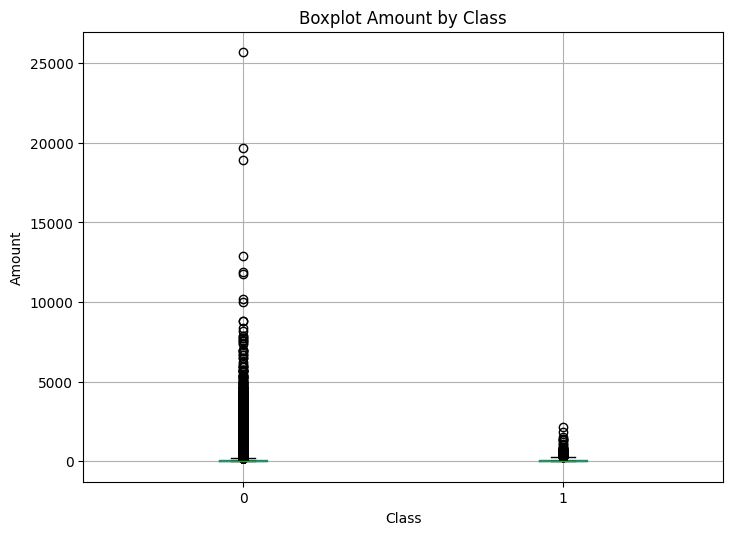

In [31]:
df.boxplot(column="Amount", by="Class", figsize=(8,6))
plt.title("Boxplot Amount by Class")
plt.suptitle("")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.show()


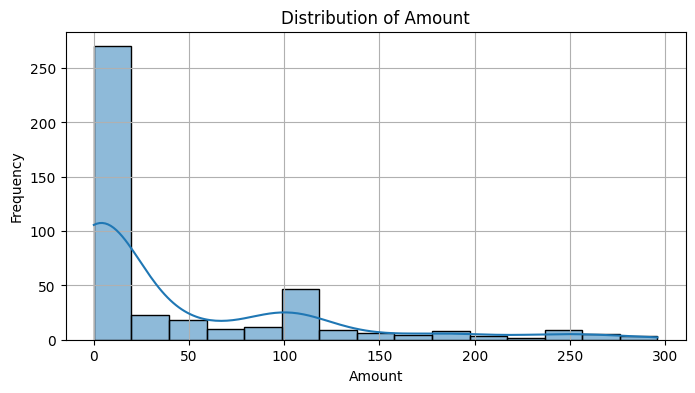

In [32]:
plot_hist_numeric(fraud, 'Amount', x_max=300)

из за маленького количества таргетов положительного класса непонятно распределение. но вот что странно: подавляющая часть - до 150$, тут есть всего 2 варианта.

1. люди не хранят на картах много денег(в выборку попали такие граждане или банковские продукты, которые не предполагают хранение на балансе большой суммы)

2. у большинства людей стоит лимит на снятие 100$(или около того, неважно) без требования пин кода. это означает что карты были физически утеряны/украдены

в том случае, если предположение верно - покупка с последующим отказом вводить пин код будет весомым индикатором положительного класса

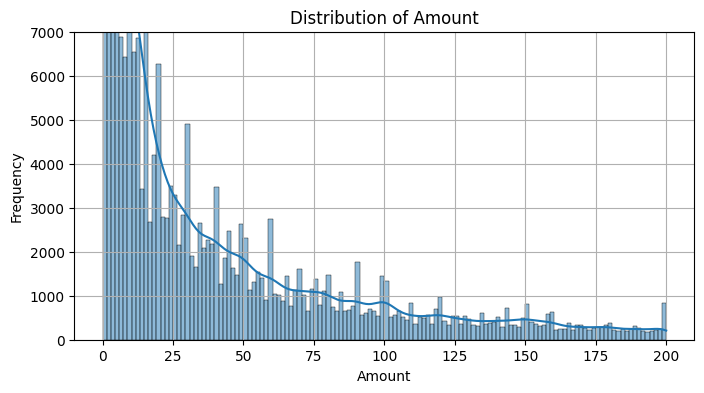

In [33]:
plot_hist_numeric(notfraud, 'Amount', x_max=200, y_max=7000)

подавляющая часть операций - до 100$, оно и понятно, если живешь 1 на 100-200$ можно закупиться на неделю. в выборку попали маленькие бытовые покупки/кафе/кофе/сигареты и подобная мелочь

interval columns not set, guessing: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


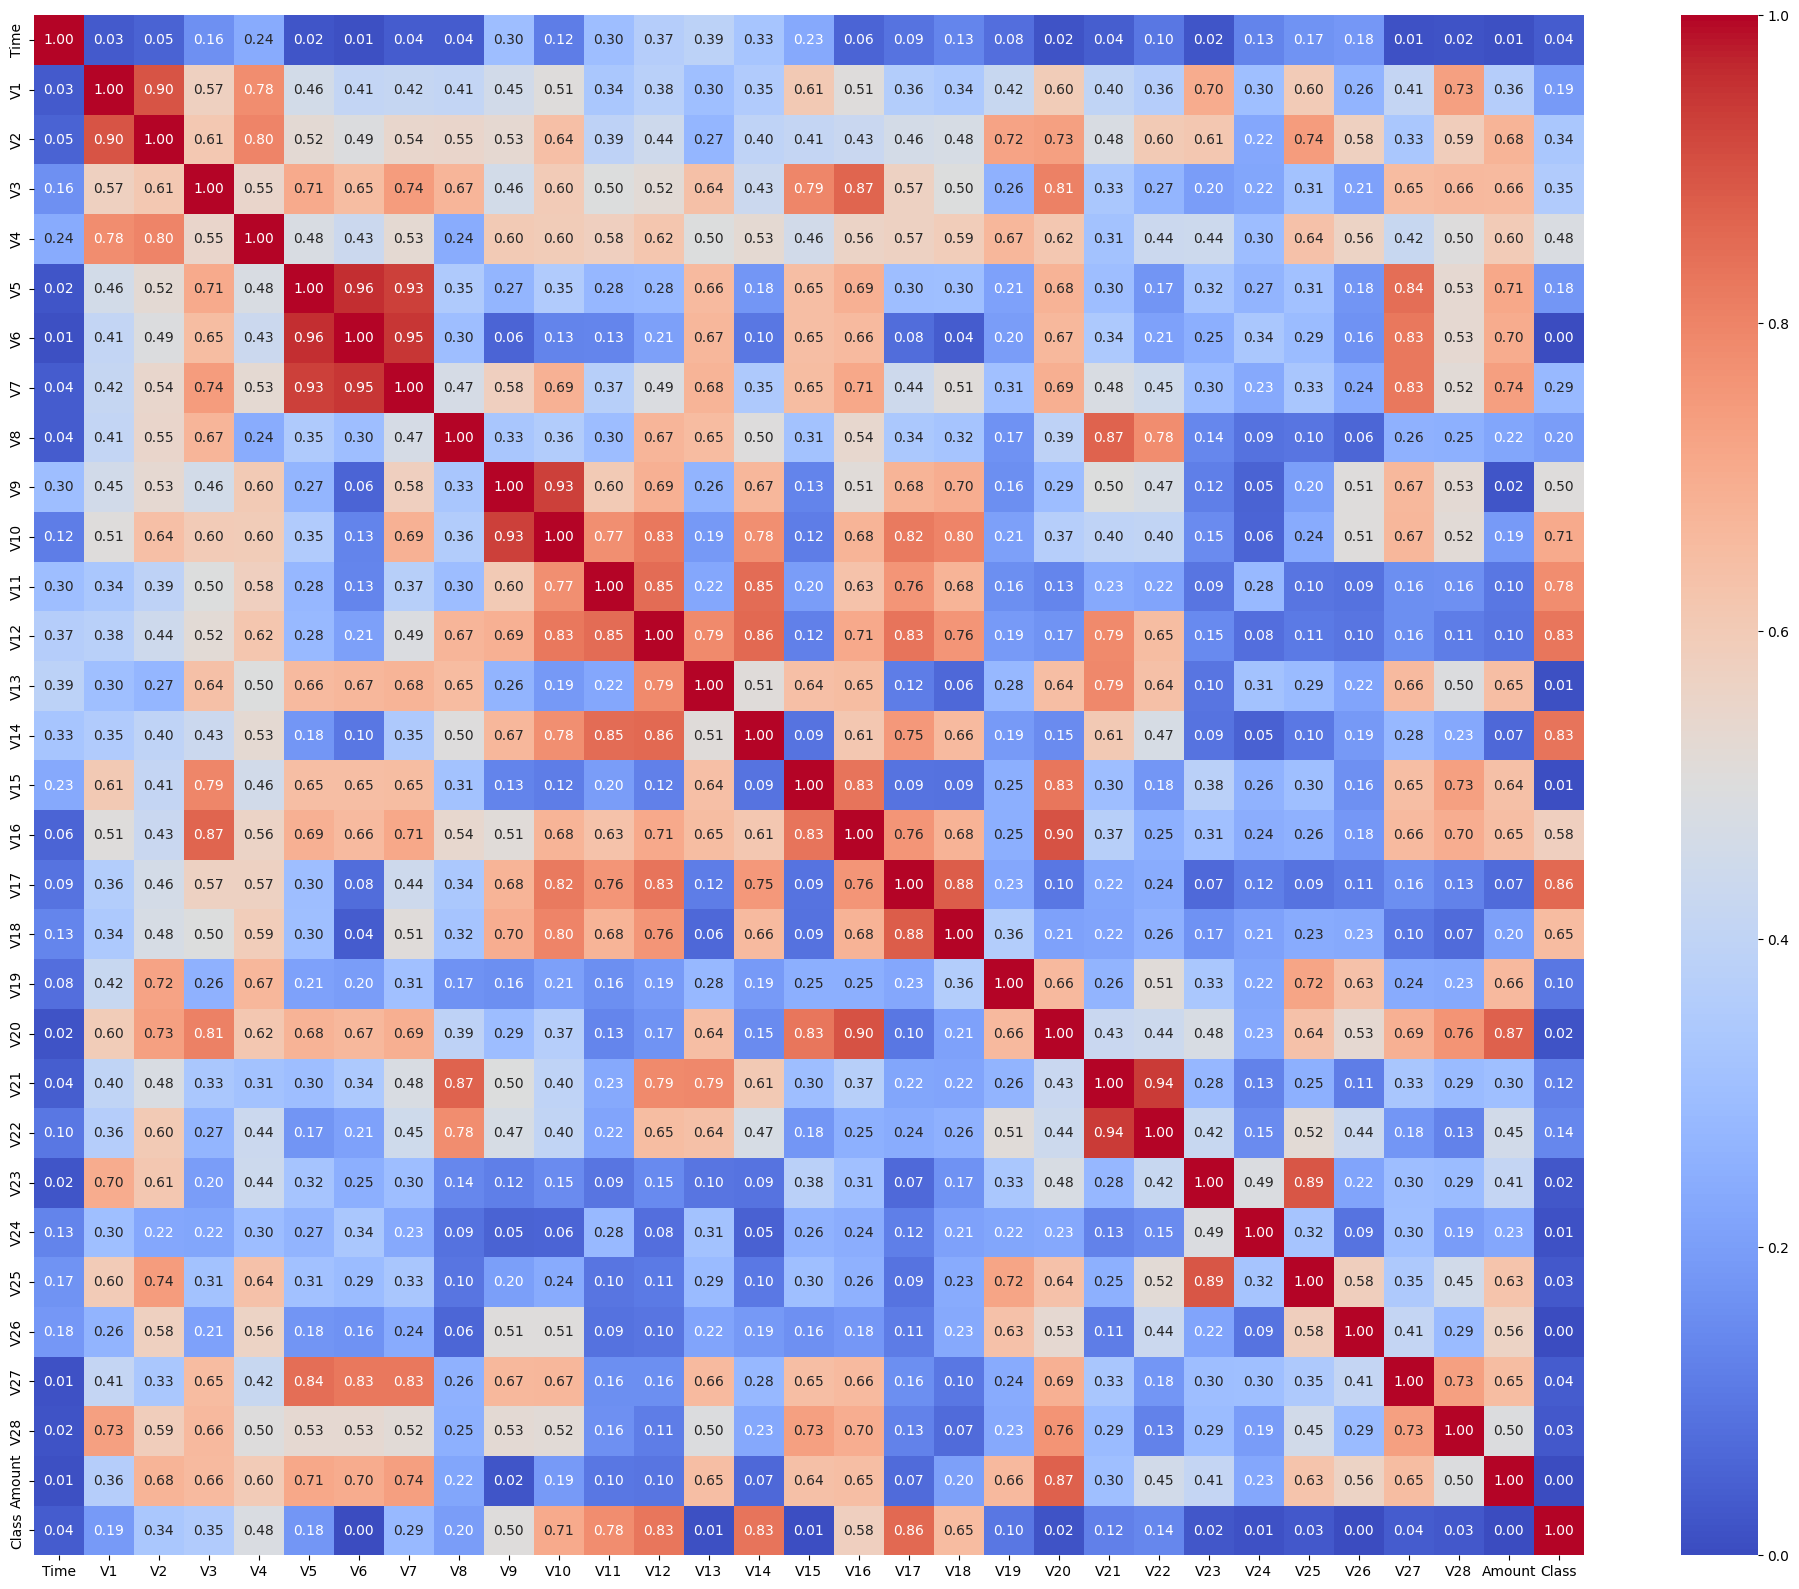

In [54]:
plot_phik(df, figsize=(25, 20))

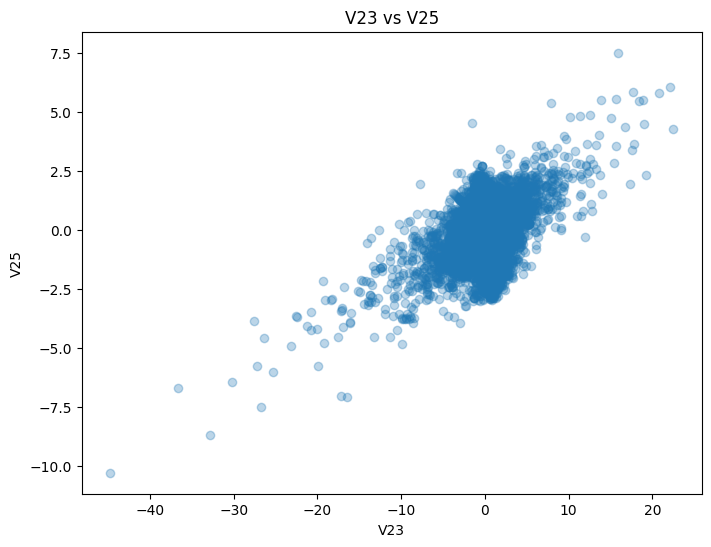

In [55]:
plt.figure(figsize=(8, 6))
plt.scatter(df['V23'], df['V25'], alpha=0.3)
plt.xlabel('V23')
plt.ylabel('V25')
plt.title('V23 vs V25')
plt.show()

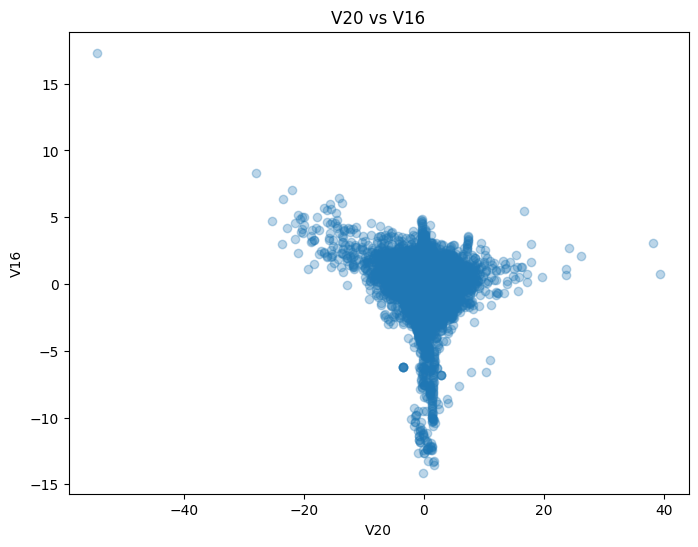

In [56]:
plt.figure(figsize=(8, 6))
plt.scatter(df['V20'], df['V16'], alpha=0.3)
plt.xlabel('V20')
plt.ylabel('V16')
plt.title('V20 vs V16')
plt.show()

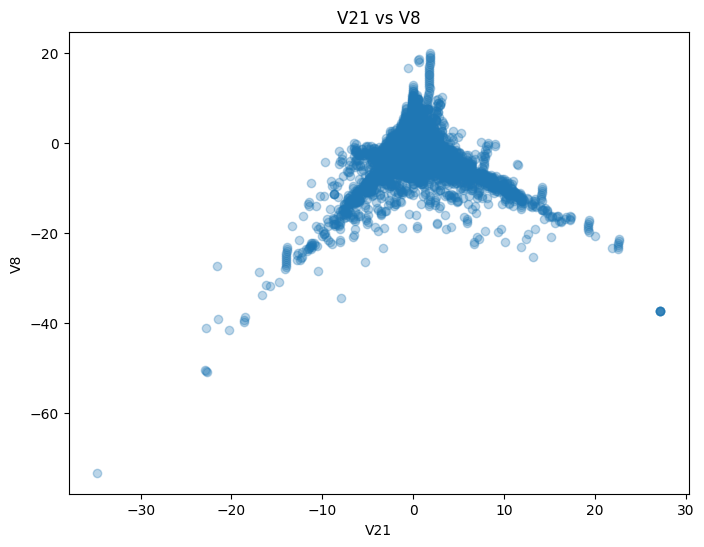

In [57]:
plt.figure(figsize=(8, 6))
plt.scatter(df['V21'], df['V8'], alpha=0.3)
plt.xlabel('V21')
plt.ylabel('V8')
plt.title('V21 vs V8')
plt.show()

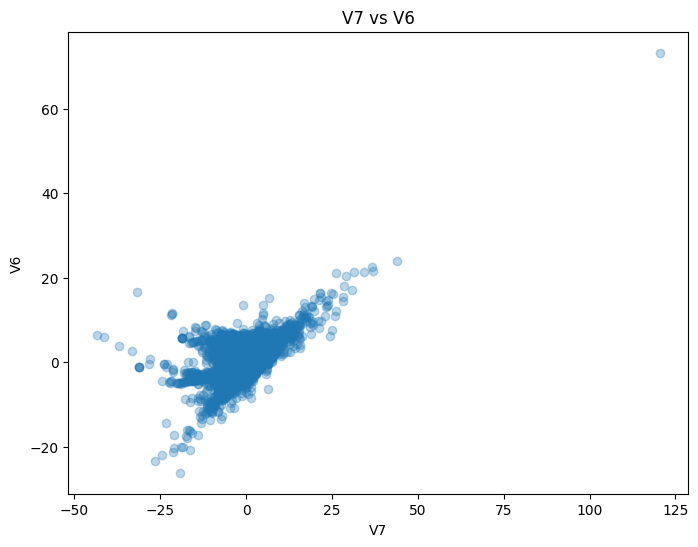

In [58]:
plt.figure(figsize=(8, 6))
plt.scatter(df['V7'], df['V6'], alpha=0.3)
plt.xlabel('V7')
plt.ylabel('V6')
plt.title('V7 vs V6')
plt.show()

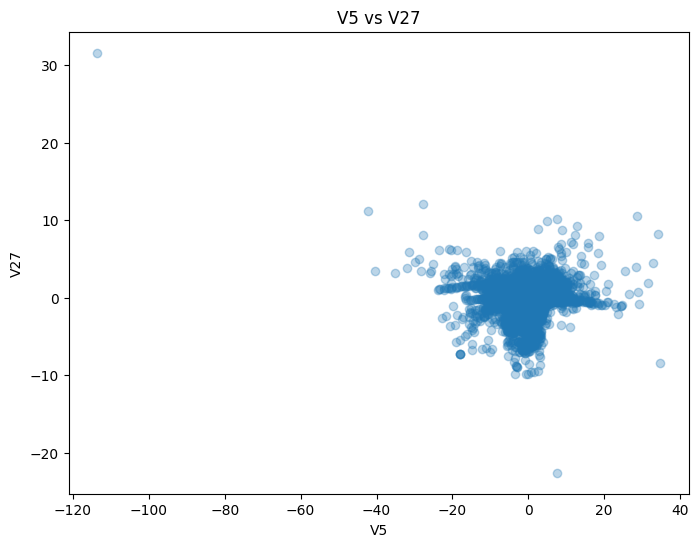

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(df['V5'], df['V27'], alpha=0.3)
plt.xlabel('V5')
plt.ylabel('V27')
plt.title('V5 vs V27')
plt.show()

Из этих графиков понятно лишь то, что самые удаленные точки предположительно являются нашими таргетами

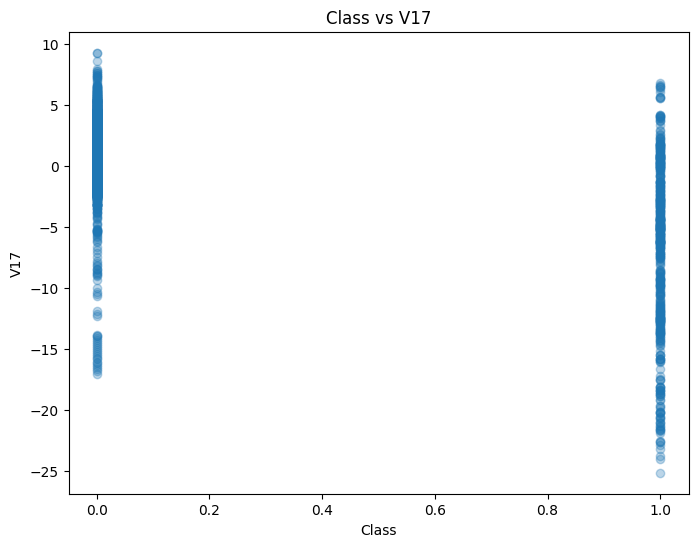

In [60]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Class'], df['V17'], alpha=0.3)
plt.xlabel('Class')
plt.ylabel('V17')
plt.title('Class vs V17')
plt.show()

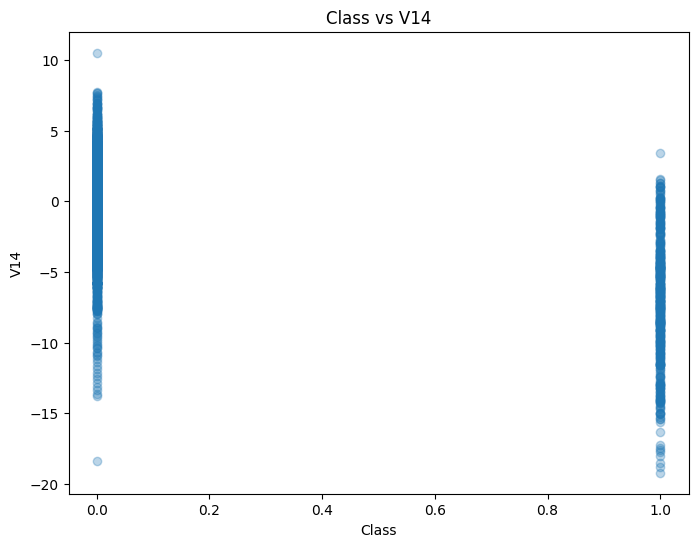

In [61]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Class'], df['V14'], alpha=0.3)
plt.xlabel('Class')
plt.ylabel('V14')
plt.title('Class vs V14')
plt.show()

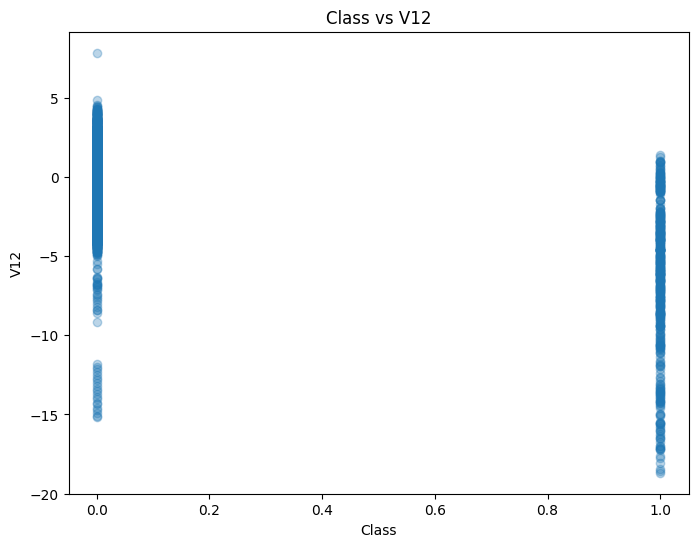

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Class'], df['V12'], alpha=0.3)
plt.xlabel('Class')
plt.ylabel('V12')
plt.title('Class vs V12')
plt.show()

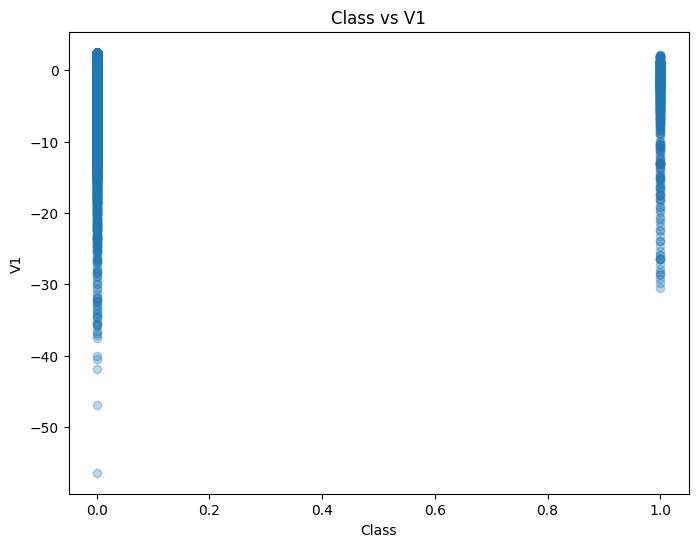

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Class'], df['V1'], alpha=0.3)
plt.xlabel('Class')
plt.ylabel('V1')
plt.title('Class vs V1')
plt.show()

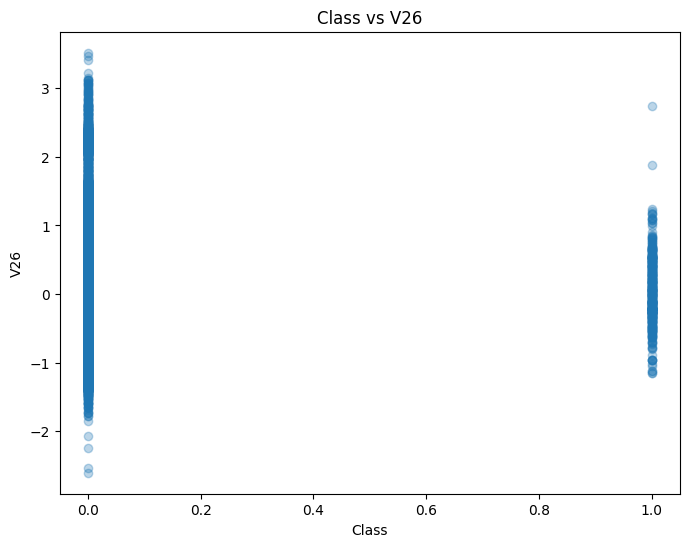

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Class'], df['V26'], alpha=0.3)
plt.xlabel('Class')
plt.ylabel('V26')
plt.title('Class vs V26')
plt.show()

из этих графиков неочевидно как класс соотносится с фичами

In [ ]:
cols_to_skip = ['Class', 'Amount', 'Time']

df_filtered = df.copy()
for col in df_filtered.select_dtypes(include='number').columns:
    if col not in cols_to_skip:
        q95 = df_filtered[col].quantile(0.99)
        df_filtered = df_filtered[df_filtered[col] <= q95]


interval columns not set, guessing: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


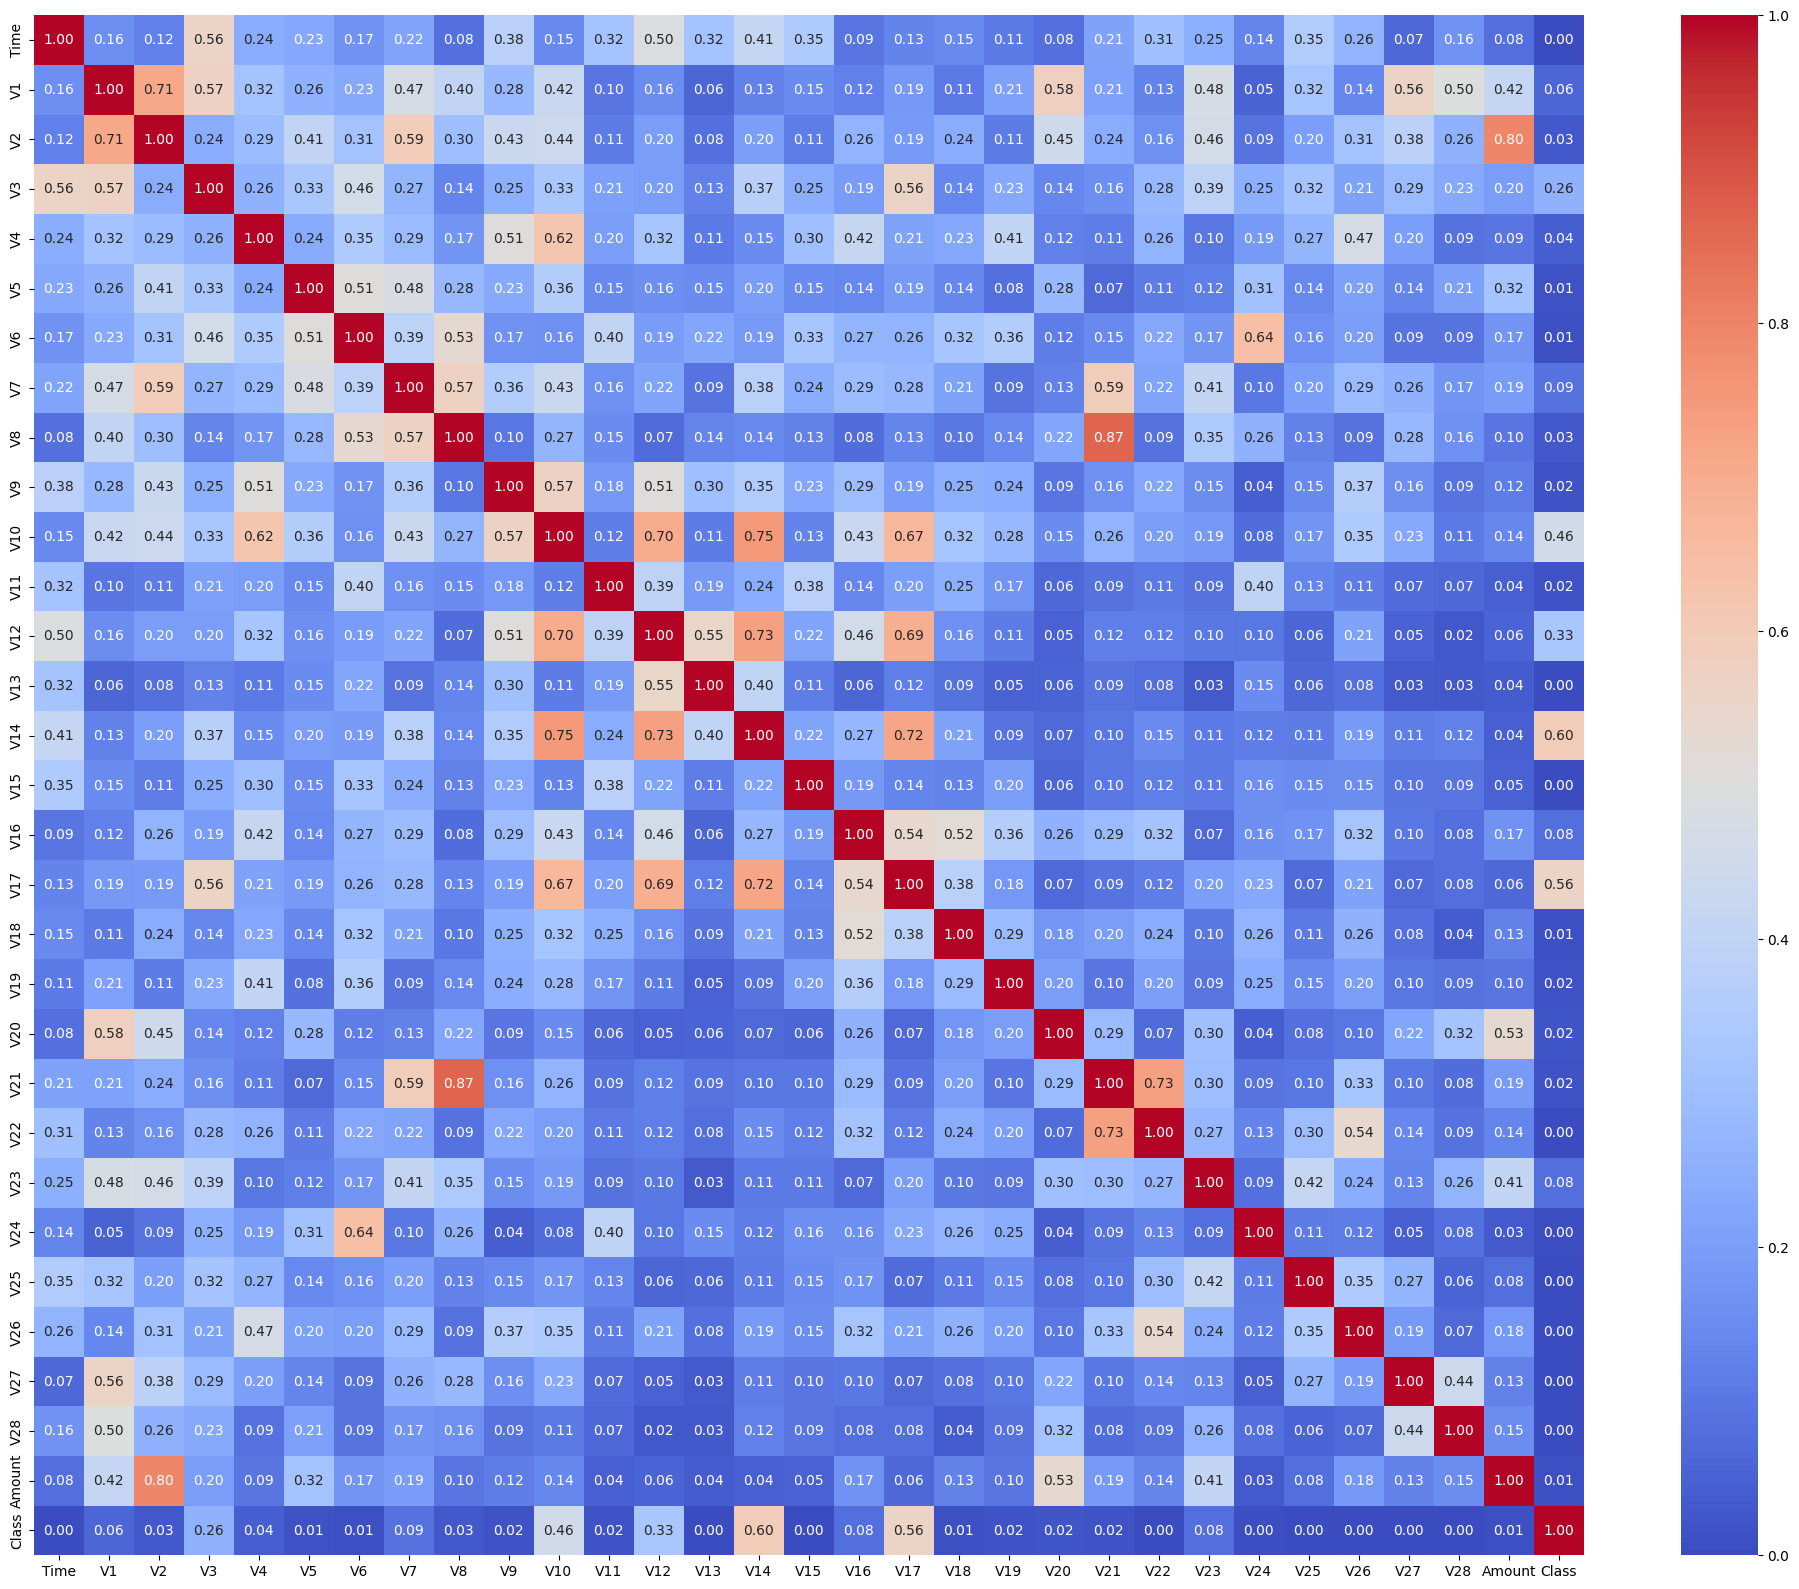

In [66]:
plot_phik(df_filtered, figsize=(25, 20))

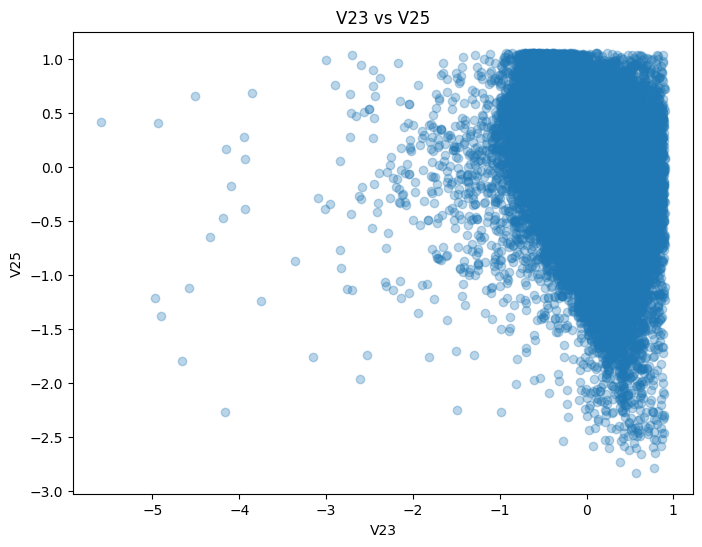

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['V23'], df_filtered['V25'], alpha=0.3)
plt.xlabel('V23')
plt.ylabel('V25')
plt.title('V23 vs V25')
plt.show()

98 квантиль сильно плющит данные. вставив в divide_data отфильтрованный датафрейм и прогнав все модели получаем присижен и реколл для положительного класса 0. оба.

99 квантиль дает Precision и Recall положительного класса 1.000000 и 0.214286 соответственно

если не делать фильтрацию, то 0.987342 0.795918

делаю вывод что даже такая маленькая обрезка приводит потере всякой информативности

поиск ошибок и выбросов - невозможен

## Baseline

In [68]:
X, y = divide_data(df, 'Class')

feature_names = X.columns.to_list()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=SEED,
)

### Dummy

d:\soft\creditcard\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\soft\creditcard\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


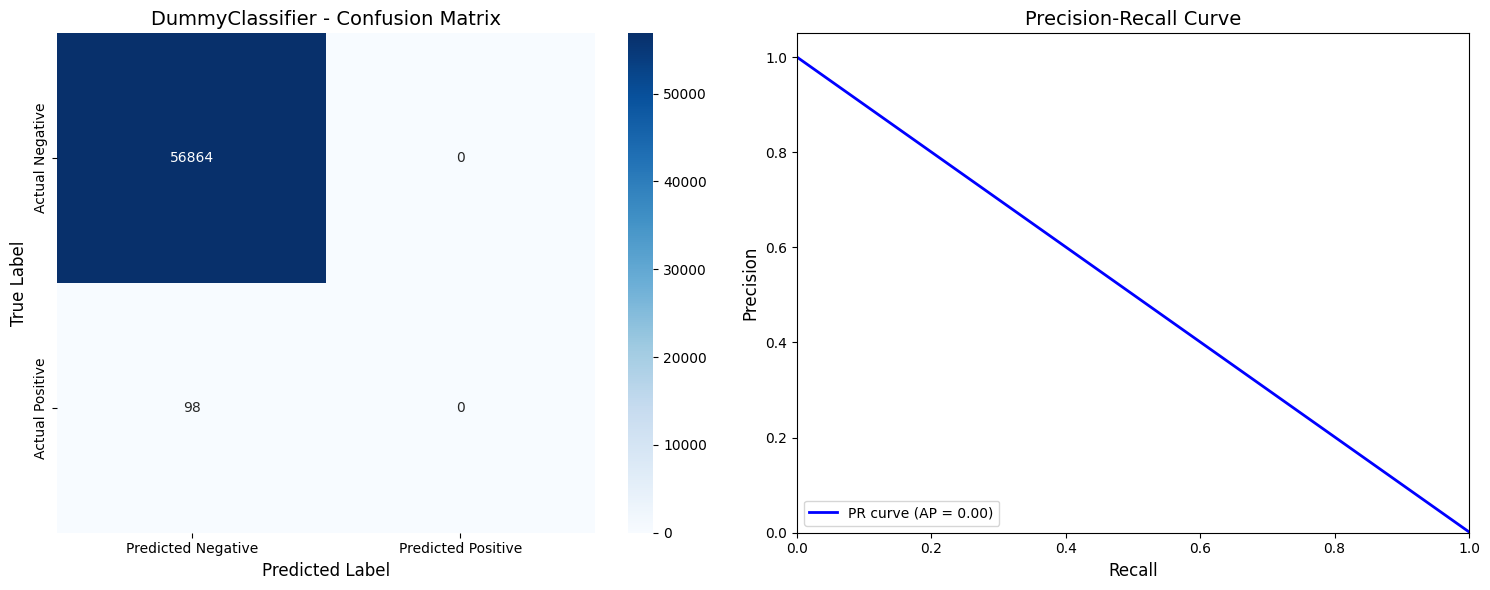


                 DUMMYCLASSIFIER EVALUATION                 

MAIN METRICS:
           Metric  Value
          ROC AUC 0.5000
Average Precision 0.0017
         F1 Score 0.4996
        Precision 0.4991
           Recall 0.5000
         Accuracy 0.9983


CLASSIFICATION REPORT:
   Class  Precision  Recall
Positive    0.00000     0.0
Negative    0.99828     1.0



In [70]:
# Задаем и обучаем модель
dummy_classifier = DummyClassifier(random_state=SEED, strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)

# Получаем предсказания
y_pred = dummy_classifier.predict(X_test) # предсказываем номер класса
y_probs = dummy_classifier.predict_proba(X_test)[:, 1] # предсказываем вероятность (необходима для построения ROC кривой)

# Считаем метрики для модели и выводим графики
dummy_classifier_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DummyClassifier",
    use_pr_curve=True
)

### Logistic

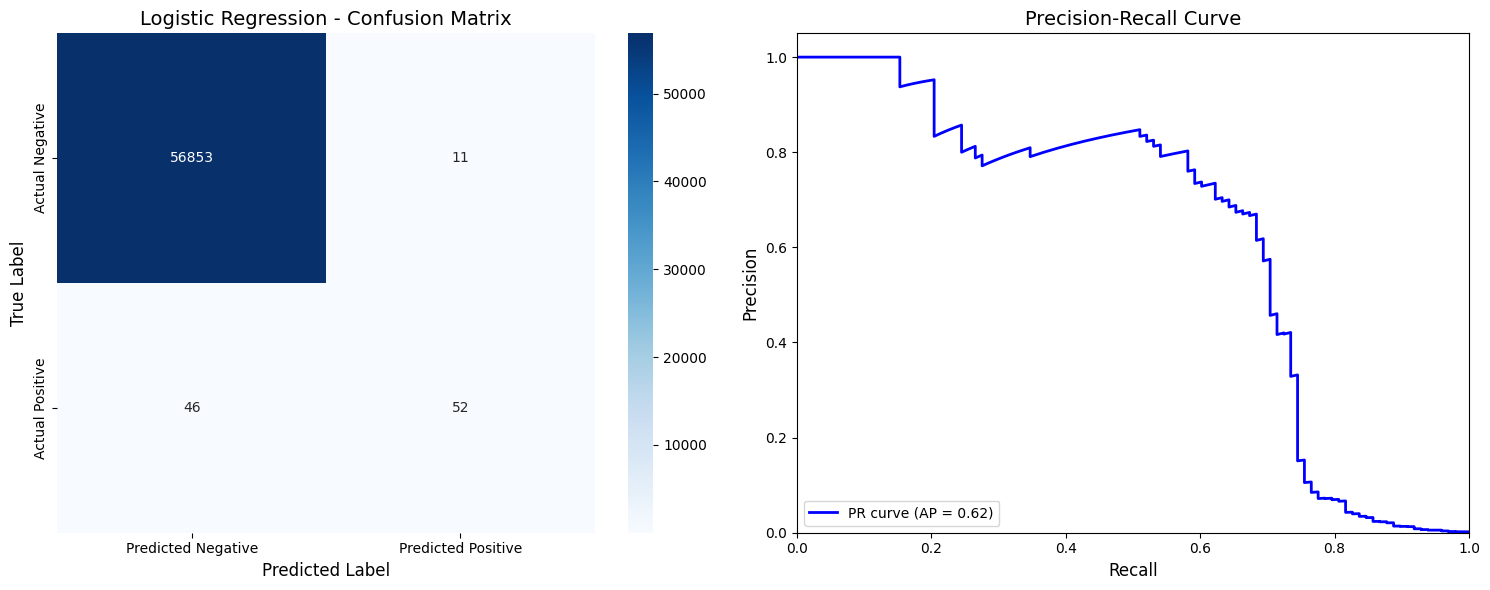


               LOGISTIC REGRESSION EVALUATION               

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9525
Average Precision 0.6203
         F1 Score 0.8227
        Precision 0.9123
           Recall 0.7652
         Accuracy 0.9990


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.825397 0.530612
Negative   0.999192 0.999807



In [71]:
log_reg = LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_probs = log_reg.predict_proba(X_test)[:, 1]  

log_reg_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="Logistic Regression",
    use_pr_curve=True
)

Американские горки. ну плохо, что сказать. реколл 53%

### Decision Tree

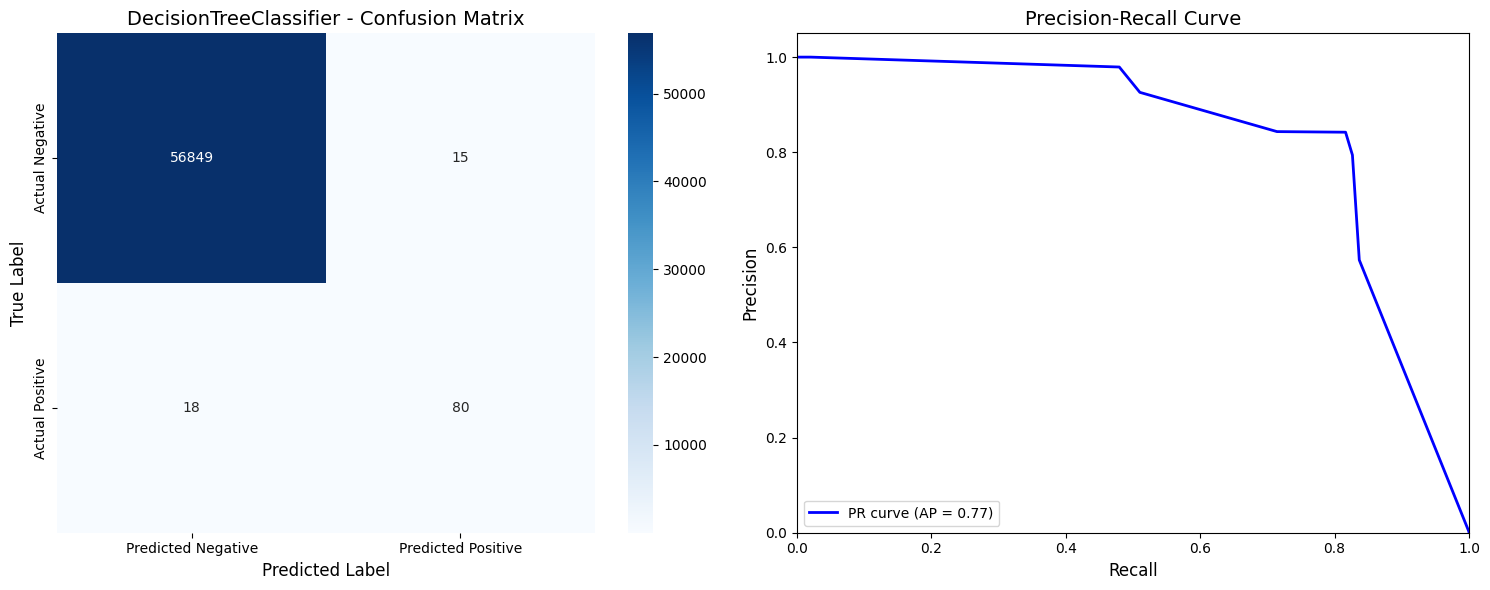


             DECISIONTREECLASSIFIER EVALUATION              

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9182
Average Precision 0.7707
         F1 Score 0.9144
        Precision 0.9209
           Recall 0.9080
         Accuracy 0.9994


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.842105 0.816327
Negative   0.999683 0.999736



In [72]:
decision_tree = DecisionTreeClassifier(random_state=SEED, max_depth=4)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
y_probs = decision_tree.predict_proba(X_test)[:, 1]  # For ROC curve

decision_tree_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="DecisionTreeClassifier",
    use_pr_curve=True
)

интересно что у дерева гладкий график

### Random Forest

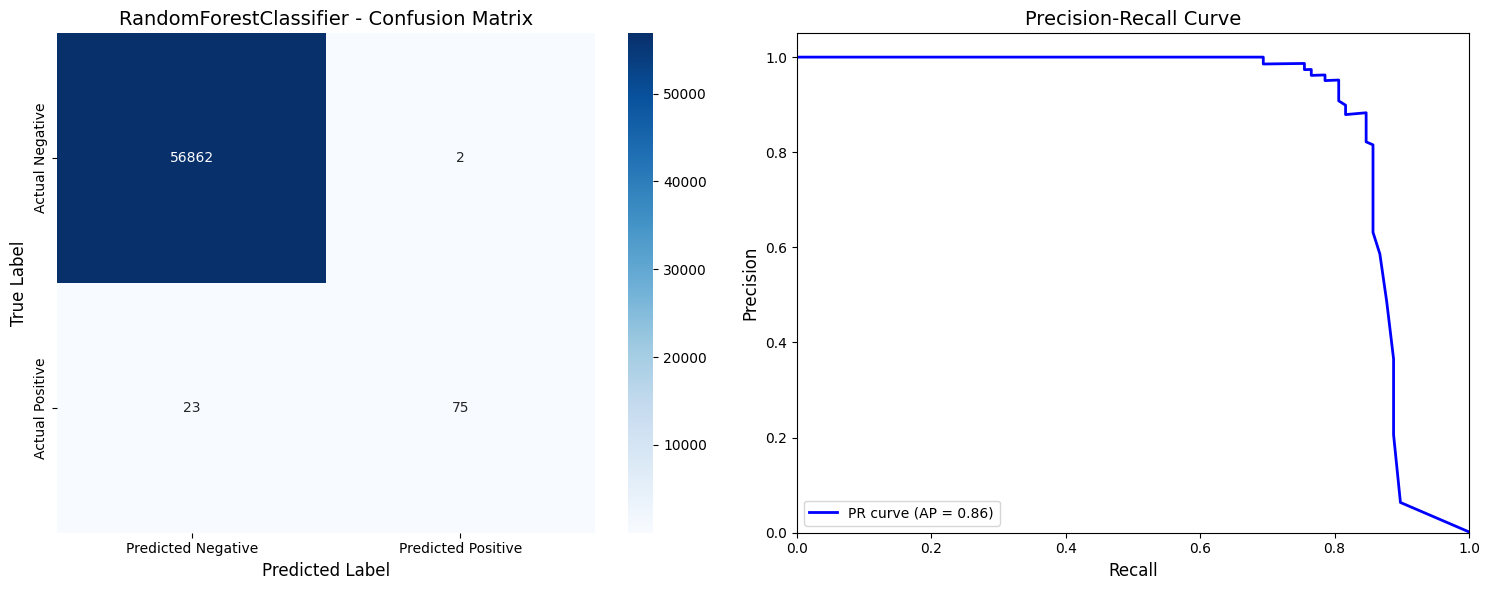


             RANDOMFORESTCLASSIFIER EVALUATION              

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9476
Average Precision 0.8632
         F1 Score 0.9285
        Precision 0.9868
           Recall 0.8826
         Accuracy 0.9996


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.974026 0.765306
Negative   0.999596 0.999965



In [73]:
# Train your model
random_forest = RandomForestClassifier(random_state=SEED)
random_forest.fit(X_train, y_train)

# Get predictions
y_pred = random_forest.predict(X_test)
y_probs = random_forest.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate
random_forest_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="RandomForestClassifier",
    use_pr_curve=True
)

### Catboost

Learning rate set to 0.104628
0:	learn: 0.3613298	total: 24.7ms	remaining: 24.7s
1:	learn: 0.2109265	total: 43.9ms	remaining: 21.9s
2:	learn: 0.1109877	total: 64.4ms	remaining: 21.4s
3:	learn: 0.0607024	total: 86.9ms	remaining: 21.6s
4:	learn: 0.0355493	total: 130ms	remaining: 25.9s
5:	learn: 0.0226898	total: 168ms	remaining: 27.8s
6:	learn: 0.0152193	total: 189ms	remaining: 26.8s
7:	learn: 0.0109353	total: 210ms	remaining: 26.1s
8:	learn: 0.0084024	total: 230ms	remaining: 25.4s
9:	learn: 0.0064731	total: 252ms	remaining: 24.9s
10:	learn: 0.0054340	total: 274ms	remaining: 24.6s
11:	learn: 0.0046469	total: 296ms	remaining: 24.4s
12:	learn: 0.0041523	total: 319ms	remaining: 24.2s
13:	learn: 0.0037806	total: 339ms	remaining: 23.8s
14:	learn: 0.0034695	total: 359ms	remaining: 23.6s
15:	learn: 0.0032814	total: 383ms	remaining: 23.6s
16:	learn: 0.0031375	total: 405ms	remaining: 23.4s
17:	learn: 0.0029938	total: 429ms	remaining: 23.4s
18:	learn: 0.0029095	total: 455ms	remaining: 23.5s
19:	lea

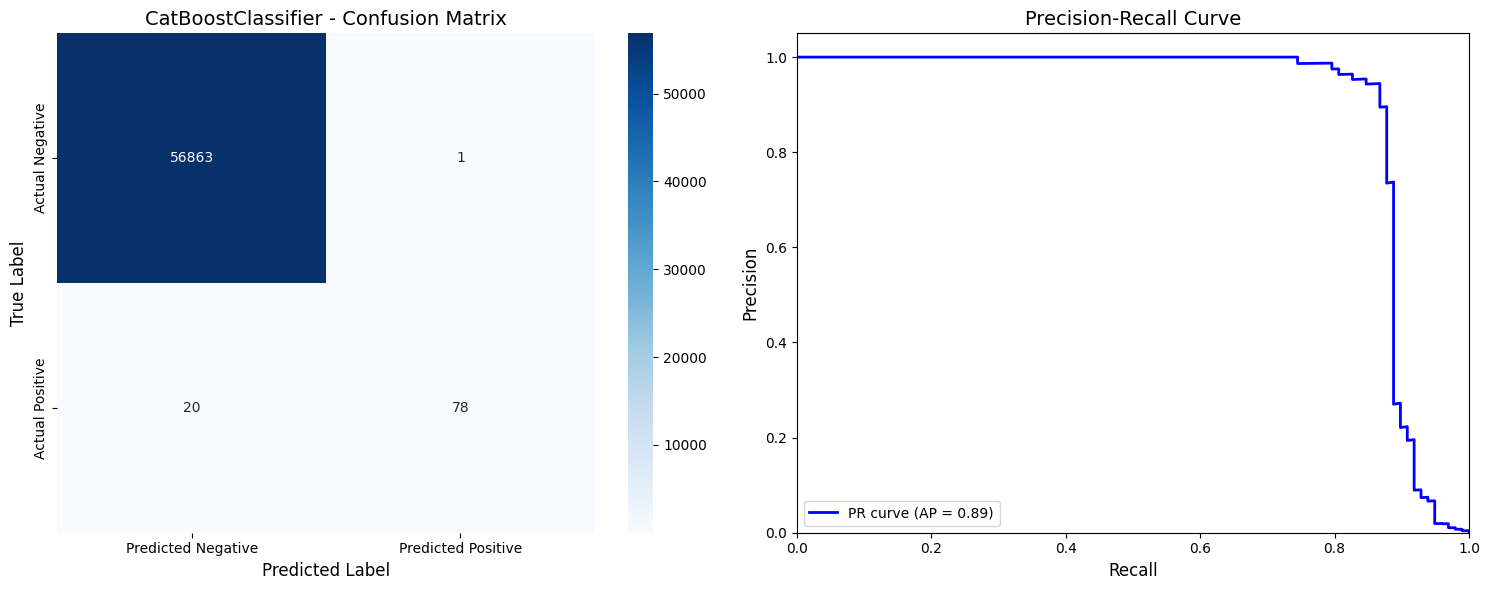


               CATBOOSTCLASSIFIER EVALUATION                

MAIN METRICS:
           Metric  Value
          ROC AUC 0.9893
Average Precision 0.8903
         F1 Score 0.9406
        Precision 0.9935
           Recall 0.8980
         Accuracy 0.9996


CLASSIFICATION REPORT:
   Class  Precision   Recall
Positive   0.987342 0.795918
Negative   0.999648 0.999982



In [74]:
# Train your model
cat = CatBoostClassifier(random_state=SEED)
cat.fit(X_train, y_train)

# Get predictions
y_pred = cat.predict(X_test)
y_probs = cat.predict_proba(X_test)[:, 1]  # For ROC curve

# Evaluate
cat_metrics = evaluate_classification(
    y_test=y_test,
    y_pred=y_pred,
    y_probs=y_probs,
    model_name="CatBoostClassifier",
    use_pr_curve=True
)

Видно резкое падение точности после охвата 80% класса

d:\soft\creditcard\plots.py:323: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


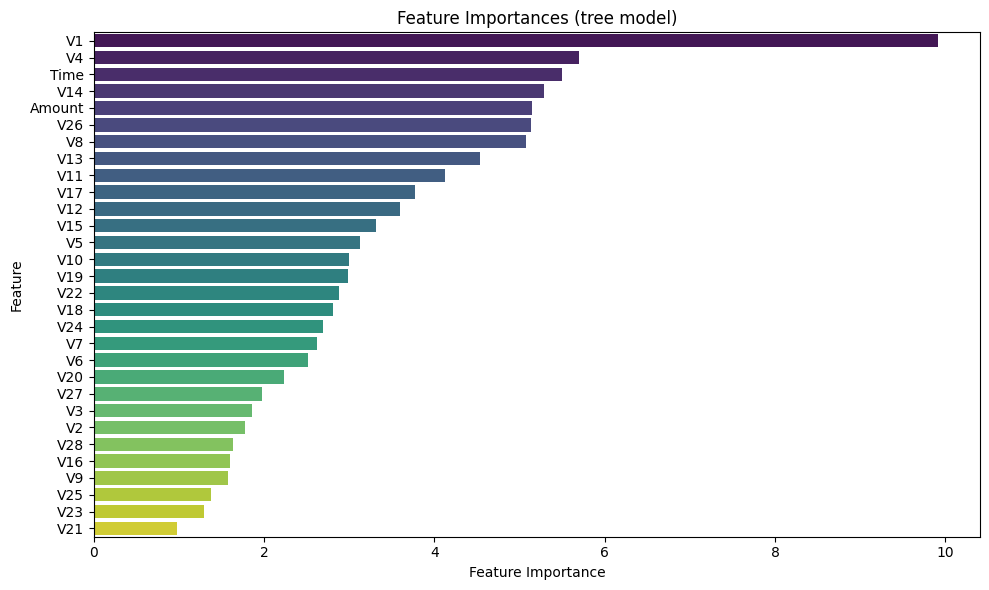

,Feature,Importance
1,V1,9.909926
4,V4,5.696624
0,Time,5.496370
14,V14,5.284756
29,Amount,5.148473
26,V26,5.130152
8,V8,5.075863
13,V13,4.532561
11,V11,4.127799
17,V17,3.767527


In [75]:
plot_feature_importance(cat, feature_names)